<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

### Load Data From CSV File  

In [5]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [6]:
df.shape

(346, 10)

### Convert to date time object 

In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

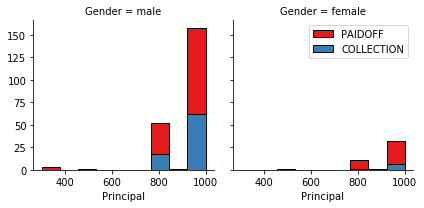

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

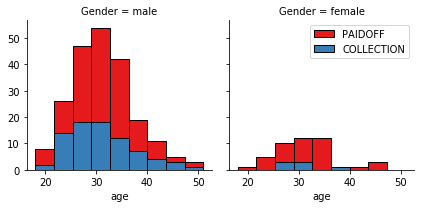

In [10]:

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

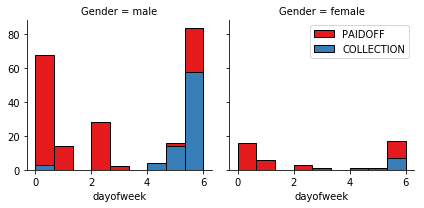

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:


df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics

In [22]:
seed=50
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.40, random_state=seed)

In [23]:
score=[]
for k in range(1,100):
    knn=KNeighborsClassifier(n_neighbors=k,weights='uniform')
    knn.fit(X_train,y_train)
    predKNN=knn.predict(X_test)
    accuracy=metrics.accuracy_score(predKNN,y_test)
    score.append(accuracy*100)
    print (k,': ',accuracy)
    

1 :  0.6906474820143885
2 :  0.5827338129496403
3 :  0.7266187050359713
4 :  0.6762589928057554
5 :  0.7482014388489209
6 :  0.6762589928057554
7 :  0.7482014388489209
8 :  0.7050359712230215
9 :  0.7769784172661871
10 :  0.7338129496402878
11 :  0.7482014388489209
12 :  0.7194244604316546
13 :  0.7482014388489209
14 :  0.7266187050359713
15 :  0.7410071942446043
16 :  0.7338129496402878
17 :  0.7482014388489209
18 :  0.7266187050359713
19 :  0.7553956834532374
20 :  0.7266187050359713
21 :  0.762589928057554
22 :  0.7194244604316546
23 :  0.762589928057554
24 :  0.7482014388489209
25 :  0.762589928057554
26 :  0.762589928057554
27 :  0.762589928057554
28 :  0.762589928057554
29 :  0.762589928057554
30 :  0.762589928057554
31 :  0.7913669064748201
32 :  0.7769784172661871
33 :  0.7913669064748201
34 :  0.7913669064748201
35 :  0.7913669064748201
36 :  0.7985611510791367
37 :  0.7841726618705036
38 :  0.7913669064748201
39 :  0.7913669064748201
40 :  0.7841726618705036
41 :  0.834532374

In [24]:
print(score.index(max(score))+1,' : ',round(max(score),2),'%')

41  :  83.45 %


WE can see that the highest accuracy achieved by K=41 as K starts from 1 not zero so the index of k is equal to (score.index(max(score))+1) with accuracy score= 83.45%

Text(0,0.5,'Train Accuracy')

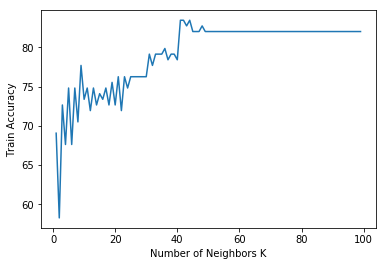

In [25]:
plt.plot(range(1,100),score)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')

In [26]:
knn=KNeighborsClassifier(n_neighbors=41,weights='uniform')
knn.fit(X_train,y_train)
predKNN=knn.predict(X_test)
accuracy=metrics.accuracy_score(predKNN,y_test)
print("accuracy : ",round(accuracy,3)*100,'%')

accuracy :  83.5 %


In [27]:
from sklearn.metrics import classification_report,jaccard_similarity_score,log_loss,f1_score
print(classification_report(y_test,predKNN))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,predKNN)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,predKNN,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, knn.predict(X_train))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.67      0.16      0.26        25
    PAIDOFF       0.84      0.98      0.91       114

avg / total       0.81      0.83      0.79       139



Jaccard Similarity Score :  83.45 %


F1-SCORE :  [0.25806452 0.90688259]


Train Accuracy:  72.46376811594203 %


# Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
dtree=DecisionTreeClassifier()

C:\Users\magic\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [29]:
parameter_grid = {'max_depth': [1, 2, 3, 4, 5,6,5,9,15,20],
                  'max_features': [1, 2, 3, 4,5,6,7,8],
                 'random_state':[0,15,20,35,50,80,100,150,180,200],
                 'criterion':['gini','entropy'],
                 }

grid_search = GridSearchCV(dtree, param_grid = parameter_grid,
                          cv =10)

grid_search.fit(X_train, y_train)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.7439613526570048
Best params: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 2, 'random_state': 0}


In [30]:
dtree=DecisionTreeClassifier(max_depth=5,criterion='entropy',max_features=2,random_state=0)

In [31]:
dtree.fit(X_train,y_train)
pred_Dtree=dtree.predict(X_test)


In [32]:
print(classification_report(y_test,pred_Dtree))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,pred_Dtree)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,pred_Dtree,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, dtree.predict(X_train))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.32      0.40      0.36        25
    PAIDOFF       0.86      0.82      0.84       114

avg / total       0.76      0.74      0.75       139



Jaccard Similarity Score :  74.1 %


F1-SCORE :  [0.35714286 0.83783784]


Train Accuracy:  77.29468599033817 %


# Support Vector Machine

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [34]:
svm=SVC().fit(X_train,y_train)

In [35]:
pred_svm=svm.predict(X_test)

In [36]:
print(classification_report(y_test,pred_svm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,pred_svm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,pred_svm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, svm.predict(X_train))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.33      0.24      0.28        25
    PAIDOFF       0.84      0.89      0.87       114

avg / total       0.75      0.78      0.76       139



Jaccard Similarity Score :  77.7 %


F1-SCORE :  [0.27906977 0.86808511]


Train Accuracy:  75.84541062801932 %


# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lgm=LogisticRegression()

In [39]:
lgm.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
pred_lgm=lgm.predict(X_test)

In [41]:
print(classification_report(y_test,pred_lgm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,pred_lgm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,pred_lgm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, lgm.predict(X_train))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.33      0.24      0.28        25
    PAIDOFF       0.84      0.89      0.87       114

avg / total       0.75      0.78      0.76       139



Jaccard Similarity Score :  77.7 %


F1-SCORE :  [0.27906977 0.86808511]


Train Accuracy:  73.91304347826086 %


# Model Evaluation using Test set

In [42]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

### Load Test set for evaluation 

In [43]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [44]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [45]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6


In [46]:
test_df['weekend']=test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)

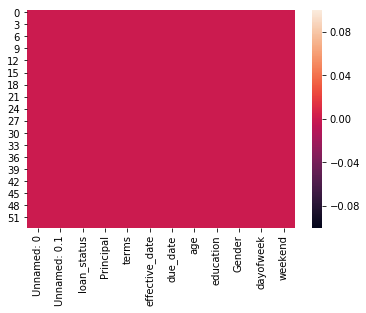

In [47]:
sns.heatmap(test_df.isnull())

In [48]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [49]:
dumm=pd.get_dummies(test_df['education'])
#dumm=dumm.drop('Master or Above',axis=1,inplace=True)
dumm=dumm[['Bechalor','High School or Below','college']]

In [50]:
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,dumm], axis=1)
#test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [51]:
test_data= test_feature
test_data= preprocessing.StandardScaler().fit(test_data).transform(test_data)

In [52]:
y_t=test_df['loan_status']

# i will use train.csv for train model, and test.csv for testing model

# KNN

In [53]:
knn=KNeighborsClassifier()
knn.fit(X,y)
predKNN_test=knn.predict(test_data)
accuracy=metrics.accuracy_score(predKNN_test,y_t)
print("accuracy : ",round(accuracy,3)*100,'%')

accuracy :  74.1 %


# BEST K FOR TEST DATA

In [54]:
score=[]
for k in range(1,100):
    knn=KNeighborsClassifier(n_neighbors=k,weights='uniform')
    knn.fit(X,y)
    predKNN=knn.predict(test_data)
    accuracy=metrics.accuracy_score(predKNN,y_t)
    score.append(accuracy*100)
    print (k,': ',accuracy)

1 :  0.7037037037037037
2 :  0.5740740740740741
3 :  0.6481481481481481
4 :  0.6296296296296297
5 :  0.7407407407407407
6 :  0.6851851851851852
7 :  0.7222222222222222
8 :  0.7037037037037037
9 :  0.7037037037037037
10 :  0.6851851851851852
11 :  0.6851851851851852
12 :  0.6666666666666666
13 :  0.7037037037037037
14 :  0.7037037037037037
15 :  0.7222222222222222
16 :  0.7037037037037037
17 :  0.7222222222222222
18 :  0.7037037037037037
19 :  0.7222222222222222
20 :  0.7407407407407407
21 :  0.7592592592592593
22 :  0.7592592592592593
23 :  0.7592592592592593
24 :  0.7222222222222222
25 :  0.7407407407407407
26 :  0.7777777777777778
27 :  0.7592592592592593
28 :  0.7777777777777778
29 :  0.7592592592592593
30 :  0.7777777777777778
31 :  0.7407407407407407
32 :  0.7962962962962963
33 :  0.7777777777777778
34 :  0.7962962962962963
35 :  0.7962962962962963
36 :  0.7777777777777778
37 :  0.7962962962962963
38 :  0.7962962962962963
39 :  0.7962962962962963
40 :  0.7962962962962963
41 :  0.7

In [55]:
print(score.index(max(score))+1,' : ',round(max(score),2),'%')

32  :  79.63 %


In [56]:
knn=KNeighborsClassifier(n_neighbors=32)
knn.fit(X,y)
predKNN_test=knn.predict(test_data)
accuracy=metrics.accuracy_score(predKNN_test,y_t)
print("accuracy : ",round(accuracy,3)*100,'%')

accuracy :  79.60000000000001 %


In [57]:
print(classification_report(y_t,predKNN_test))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_t,predKNN_test)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_t,predKNN_test,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y,knn.predict(X))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.71      0.36      0.48        14
    PAIDOFF       0.81      0.95      0.87        40

avg / total       0.78      0.80      0.77        54



Jaccard Similarity Score :  79.63 %


F1-SCORE :  [0.47619048 0.87356322]


Train Accuracy:  74.85549132947978 %


# Decision tree

#### BEST PARAMETERS FOR DECISION TREE

In [58]:
parameter_grid = {'max_depth': [1, 2, 3, 4, 5,6,5,9,15,20],
                  'max_features': [1, 2, 3, 4,5,6,7,8],
                 'random_state':[0,15,20,35,50,80,100,150,180,200],
                 'criterion':['gini','entropy'],
                 }

grid_search = GridSearchCV(dtree, param_grid = parameter_grid,
                          cv =10)

grid_search.fit(X, y)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.7687861271676301
Best params: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 4, 'random_state': 20}


In [59]:
dtree=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=4,random_state=20).fit(X,y)
pred_Dtree=dtree.predict(test_data)

In [60]:
print(classification_report(y_t,pred_Dtree))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_t,pred_Dtree)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_t,pred_Dtree,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y, dtree.predict(X))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.44      0.29      0.35        14
    PAIDOFF       0.78      0.88      0.82        40

avg / total       0.69      0.72      0.70        54



Jaccard Similarity Score :  72.22 %


F1-SCORE :  [0.34782609 0.82352941]


Train Accuracy:  79.47976878612717 %


# SVM

In [61]:
svm=SVC().fit(X,y)
pred_svm=svm.predict(test_data)

In [62]:
print(classification_report(y_t,pred_svm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_t,pred_svm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_t,pred_svm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y, svm.predict(X))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        14
    PAIDOFF       0.74      0.97      0.84        40

avg / total       0.55      0.72      0.62        54



Jaccard Similarity Score :  72.22 %


F1-SCORE :  [0.         0.83870968]


Train Accuracy:  76.01156069364163 %


# LOGISTIC REGRESSION

In [63]:
lgm=LogisticRegression().fit(X,y)

In [64]:
pred_lgm=lgm.predict(test_data)


In [65]:
print(classification_report(y_t,pred_lgm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_t,pred_lgm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_t,pred_lgm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y, lgm.predict(X))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       1.00      0.07      0.13        14
    PAIDOFF       0.75      1.00      0.86        40

avg / total       0.82      0.76      0.67        54



Jaccard Similarity Score :  75.93 %


F1-SCORE :  [0.13333333 0.86021505]


Train Accuracy:  75.43352601156069 %


In [66]:
Algoritm=['KNN','Decision Tree','SVM','LogisticRegression']
j_knn=round(jaccard_similarity_score(y_t,predKNN_test)*100,2)
j_dtree=round(jaccard_similarity_score(y_t,pred_Dtree)*100,2)
j_svm=round(jaccard_similarity_score(y_t,pred_svm)*100,2)
j_lgm=round(jaccard_similarity_score(y_t,pred_lgm)*100,2)
Jaccard=[j_knn,j_dtree,j_svm,j_lgm]

f1_knn=f1_score(y_t,predKNN_test,average=None)
f1_dtree=f1_score(y_t,pred_Dtree,average=None)
f1_svm=f1_score(y_t,pred_svm,average=None)
f1_lgm=f1_score(y_t,pred_lgm,average=None)
F1_score=[f1_knn,f1_dtree,f1_svm,f1_lgm]

In [67]:
table = pd.DataFrame({
    "Algorithm": Algoritm,
    "Jaccatd": Jaccard,
    "F1-Score": F1_score,
    "LogLoss":[np.NAN,np.NAN,np.NAN,np.NAN]})

In [68]:
table

,Algorithm,Jaccatd,F1-Score,LogLoss
0,KNN,79.63,"[0.4761904761904762, 0.8735632183908046]",NaN
1,Decision Tree,72.22,"[0.34782608695652173, 0.823529411764706]",NaN
2,SVM,72.22,"[0.0, 0.8387096774193549]",NaN
3,LogisticRegression,75.93,"[0.13333333333333333, 0.8602150537634409]",NaN
